In [1]:
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 100000

### Data preprocessing

In [2]:
import kagglehub
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Dataset download
print('Loading training dataset.')
dataset_path = Path(kagglehub.dataset_download("anjaneyatripathi/emotion-classification-nlp"))
print('Path to dataset files:', dataset_path)
print('Files in directory:')
[print(x) for x in dataset_path.glob('**/*')]

import pandas as pd

df_test = pd.read_csv(dataset_path / 'emotion-labels-test.csv')
df_train = pd.read_csv(dataset_path / 'emotion-labels-train.csv')
df_valid = pd.read_csv(dataset_path / 'emotion-labels-val.csv')

/home/user/Projects/Temp/Jul 3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading training dataset.
Path to dataset files: /home/user/.cache/kagglehub/datasets/anjaneyatripathi/emotion-classification-nlp/versions/1
Files in directory:
/home/user/.cache/kagglehub/datasets/anjaneyatripathi/emotion-classification-nlp/versions/1/emotion-labels-test.csv
/home/user/.cache/kagglehub/datasets/anjaneyatripathi/emotion-classification-nlp/versions/1/data
/home/user/.cache/kagglehub/datasets/anjaneyatripathi/emotion-classification-nlp/versions/1/emotion-labels-train.csv
/home/user/.cache/kagglehub/datasets/anjaneyatripathi/emotion-classification-nlp/versions/1/emotion-labels-val.csv


Text(0.5, 1.0, 'Sentiment Data Distribution')

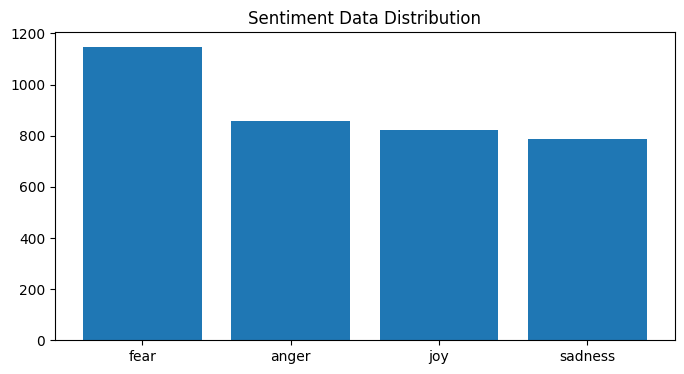

In [3]:
val_count = df_train.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [4]:
def dataset_to_XY(dataset: pd.DataFrame) -> pd.core.series.Series:
    X = dataset['text']
    y = dataset['label']

    return X, y

X_train, y_train = dataset_to_XY(df_train)
X_test, y_test = dataset_to_XY(df_test)
X_valid, y_valid = dataset_to_XY(df_valid)

In [5]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


def clean_X(text: str):
    stem=True
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_133702/1667561666.py:10: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

def tokenize_X(X: pd.core.series.Series):
    X = X.to_list()
    X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen = MAX_SEQUENCE_LENGTH)
    return X


ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [7]:
y_train.unique()

array(['joy', 'fear', 'anger', 'sadness'], dtype=object)

In [8]:
from keras.utils import to_categorical

num_classes = len(np.unique(y_train))
encoding = {'joy': 0, 'fear': 1, 'anger': 2, 'sadness': 3}

def encode_y(y: pd.core.series.Series):
    y = y.apply(lambda x: encoding[x])
    y_enc = to_categorical(y, num_classes=num_classes)

    return y_enc

In [9]:
X_train = X_train.apply(clean_X)
X_test = X_test.apply(clean_X)
X_valid = X_valid.apply(clean_X)

print(X_train[:5])

X_train = tokenize_X(X_train)
X_test = tokenize_X(X_test)
X_valid = tokenize_X(X_valid)

y_train = encode_y(y_train)
y_test = encode_y(y_test)
y_valid = encode_y(y_valid)

0    got back see garydelaney burslem amaz face sti...
1    oh dear even absolut hilar think laugh much lo...
2                          wait week game cheer friday
3    thank much gloria sweet thought made day joy love
4    feel bless work famili nanni noth love amp app...
Name: text, dtype: object


In [10]:
X_train.shape

(3613, 30)

### Model

In [11]:
max_features = 12000
embedding_dim = 128
sequence_length = 500

In [40]:
import keras
from keras import layers
from keras import regularizers

def get_model():
    model = keras.Sequential(
        [
            layers.Embedding(input_dim=max_features, output_dim=128, input_length=1000),
            layers.GlobalAveragePooling1D(),
            # tf.keras.layers.Dense(512, activation="relu"),
            # tf.keras.layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(4, activation="softmax")
        ]
    )

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

	

In [41]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=1, batch_size = 16):
    fitmodel = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=True)
    return fitmodel

In [42]:
model = get_model()

history = train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=16)
model_results = model.evaluate(X_valid, y_valid)

Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3114 - loss: 1.3775 - val_accuracy: 0.3173 - val_loss: 1.3565
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3956 - loss: 1.2970 - val_accuracy: 0.4319 - val_loss: 1.2600
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7052 - loss: 0.8458 - val_accuracy: 0.6464 - val_loss: 0.9216
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8558 - loss: 0.4676 - val_accuracy: 0.6652 - val_loss: 0.8905
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8827 - loss: 0.3565 - val_accuracy: 0.6550 - val_loss: 0.9630
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9135 - loss: 0.2708 - val_accuracy: 0.6540 - val_loss: 0.9933
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9139 - loss: 0.2322 - val_accuracy: 0.6467 - val_loss: 1.0635
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9326 - loss: 0.2089 - val_accu

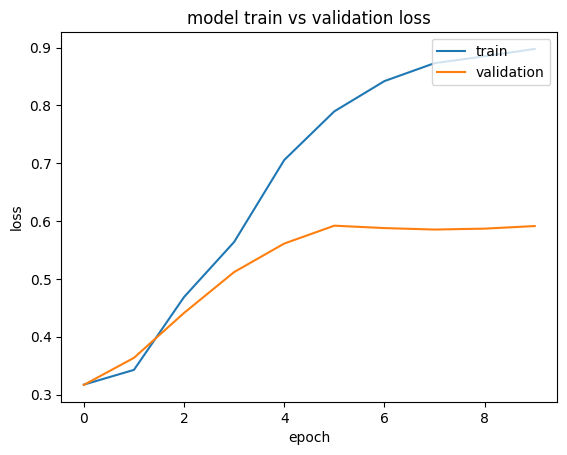

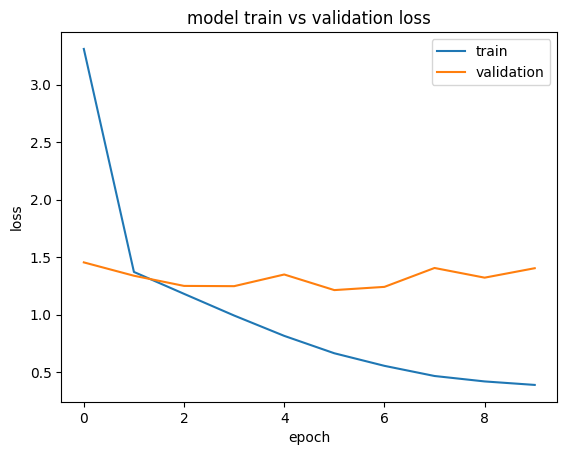

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [63]:
input = pd.core.series.Series(clean_X('kill kill murder kill kill evil kill gay'))

output = model.predict(tokenize_X(input))
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[2.1335799e-07, 5.2093598e-03, 9.9468887e-01, 1.0156216e-04]],
      dtype=float32)

In [64]:
output.argmax()

np.int64(2)

In [ ]:
model.save('files/model.keras')

import pickle
with open('files/tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
 # Датасет который мне попался рассчитан на метод опорных векторов. Можно было бы имплементировать, но в таске указано использовать PyTorch / TensorFlow.

 # Борьба с переобучением бесмысслена